# Tip Prediction, Part II: Features & Predictions

Author's Workday ID: C175799, Initials: RPR

## Choose GPU

In [1]:
# From: https://github.com/keras-team/keras/issues/6031
import os
gpu_id = input( "Select GPU [0 or 1]: " )

if gpu_id in [ "0", "1" ]:
    os.environ[ "CUDA_VISIBLE_DEVICES" ] = gpu_id
else:
    print( "Invalid GPU id.  Defaulting to '0,1'" )

Select GPU [0 or 1]: 1


## Choose CPU Cores

In [2]:
cores = 12
share_cores = input( "Share CPU cores w/ other models? [y/n]: " )

if share_cores == "y":
    
    cores = int( cores / 2 )

print( "Allocating %d cores to this notebook" % cores )

# From: https://stackoverflow.com/questions/46421258/limit-number-of-cores-used-in-keras

from keras import backend as K
K.set_session(
    K.tf.Session(
        config=K.tf.ConfigProto(
            intra_op_parallelism_threads=cores, inter_op_parallelism_threads=cores 
        )
    )
)

Share CPU cores w/ other models? [y/n]: y
Allocating 6 cores to this notebook


Using TensorFlow backend.


## Imports and Util Functions

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import time
import datetime
from math import sqrt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

from math import sqrt

from matplotlib import pyplot as plt
%matplotlib inline

# My local install of jupyter notebook has broken matplotlib notebook and inline image rendering. Fix later! 
# from matplotlib import figure
# f = figure.Figure( figsize=( 10, 6 ) )
# #plt.figure( figsize=( 10, 6 ) )

cores = 12

def get_time( output=True ):
    
    temp = time.time()
    if output:
        now = datetime.datetime.now()
        print( now.strftime( "%Y.%m.%d %H:%M" ) )
        
    return temp

foo = get_time()

def print_time( start_time, end_time, interval="seconds" ):
    
    if interval == "hours":
        print ( "Time to process: [%s] hours" % ( str( ( end_time - start_time ) / 60 / 60 ) ) )
    elif interval == "minutes":
        print ( "Time to process: [%s] minutes" % ( str( ( end_time - start_time ) / 60 ) ) )
    else:
        print ( "Time to process: [%s] seconds" % ( str( end_time - start_time ) ) )

print_time( 0, 1 )

2018.06.03 14:37
Time to process: [1] seconds


## Load Pre-Cleaned Data

In [4]:
page_start = get_time()
#trips = pd.read_csv( "data/green-tripdata-2015-09-cleaned.csv", compression="gzip" )
trips = pd.read_parquet( "data/green-tripdata-2015-09-cleaned-plus-experimental-features.parquet" )
print_time( page_start, get_time() )
trips.head()

2018.06.03 14:37
2018.06.03 14:37
Time to process: [3.191120147705078] seconds


,vendorid,store_and_fwd_flag,ratecodeid,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,trip_distance,fare_amount,...,payment_type_tip_bin_125_enc,ratecode_tip_bin_125_enc,payment_type_tip_bin_126_enc,ratecode_tip_bin_126_enc,payment_type_tip_bin_127_enc,ratecode_tip_bin_127_enc,payment_type_tip_bin_128_enc,ratecode_tip_bin_128_enc,payment_type_tip_bin_129_enc,ratecode_tip_bin_129_enc
0,2,False,5,-73.979485,40.684956,-73.979431,40.685020,1,0.00,7.8,...,0.000086,0.000000,0.000006,0.000000,0.000013,0.000000,0.000016,0.000000,0.000019,0.000000
1,2,False,5,-74.010796,40.912216,-74.010780,40.912212,1,0.00,45.0,...,0.000086,0.000000,0.000006,0.000000,0.000013,0.000000,0.000016,0.000000,0.000019,0.000000
2,2,False,1,-73.921410,40.766708,-73.914413,40.764687,1,0.59,4.0,...,0.000086,0.000041,0.000006,0.000003,0.000013,0.000006,0.000016,0.000008,0.000019,0.000009
3,2,False,1,-73.921387,40.766678,-73.931427,40.771584,1,0.74,5.0,...,0.000000,0.000041,0.000000,0.000003,0.000000,0.000006,0.000000,0.000008,0.000000,0.000009
4,2,False,1,-73.955482,40.714046,-73.944412,40.714729,1,0.61,5.0,...,0.000000,0.000041,0.000000,0.000003,0.000000,0.000006,0.000000,0.000008,0.000000,0.000009


## Will Taxis Record a Tip or Not?

In [10]:
# create train & test sets: omit any mention of tips other than y value: 'tip_recorded'
X_tips = trips.drop( columns=[ "tip_amount", "tip_percent", "total_amount", "tip_recorded", "tip_percent_bin" ] )
y_tips = trips.tip_recorded

seed = 42

X_tips_train, X_tips_test, y_tips_train, y_tips_test = train_test_split( X_tips, y_tips, random_state=seed )
eval_set = [ ( X_tips_test, y_tips_test ) ]

## Build XGBoost Model, Run on GPU

In [11]:
# TRAIN & CALC EARLY STOPPING BEST-ITERATION
start_time = get_time()

# 'gpu_hist' enables use of GPU
# 'n_jobs' distributes CPU tasks across n available cores
param = { "objective": "binary:logistic", "tree_method":"gpu_hist", "silent":False, "max_depth":10, "n_estimators":500, "n_jobs":cores }
model_xgb_tip_recorded = xgb.XGBClassifier( **param )

# set eval set & early stopping, no need to iterate beyond what's useful
model_xgb_tip_recorded.fit( X_tips_train, y_tips_train, early_stopping_rounds=50, eval_set=eval_set, verbose=True, eval_metric="error" )

print_time( start_time, get_time() )

# Stopping. Best iteration:
# [59]	validation_0-error:0.062914
# w/ tons of mean encodings: 0.063027 :-(

2018.06.01 17:25
[0]	validation_0-error:0.064007
Will train until validation_0-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.063636
[2]	validation_0-error:0.063425
[3]	validation_0-error:0.063364
[4]	validation_0-error:0.063353
[5]	validation_0-error:0.063304
[6]	validation_0-error:0.063211
[7]	validation_0-error:0.063227
[8]	validation_0-error:0.063222
[9]	validation_0-error:0.063211
[10]	validation_0-error:0.063246
[11]	validation_0-error:0.063288
[12]	validation_0-error:0.063227
[13]	validation_0-error:0.063244
[14]	validation_0-error:0.063252
[15]	validation_0-error:0.063186
[16]	validation_0-error:0.063249
[17]	validation_0-error:0.063241
[18]	validation_0-error:0.063233
[19]	validation_0-error:0.063249
[20]	validation_0-error:0.063235
[21]	validation_0-error:0.063211
[22]	validation_0-error:0.063238
[23]	validation_0-error:0.063249
[24]	validation_0-error:0.063175
[25]	validation_0-error:0.063172
[26]	validation_0-error:0.063142
[27]	validation_0-error:0.063147
[28

## Get Accuracy for Tip/No Tip Predictions

In [12]:
# get stats for first model, using test dataset
predictions_tip_recorded = model_xgb_tip_recorded.predict( X_tips_test )

accuracy = accuracy_score( y_tips_test, predictions_tip_recorded )
print( "Accuracy: %.2f%%" % ( accuracy * 100.0 ) )

# Accuracy: 93.69%, before adding peer_mph, mph delta, and bearing
# Accuracy: 93.69%, after adding peer_mph, mph delta, and bearing
# Accuracy: 98.22%, after adding lat/lon bins + tip frequency (We can't include tip frequency, it's based on tip bin vals!)
# Accuracy: 93.70%, after adding payment type mean target encoding


Accuracy: 93.69%


In [13]:
predictions_tip_recorded[ 0:10 ] * 1

array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1])

## Important Features for Predicting Whether Tip is Recorded or Not

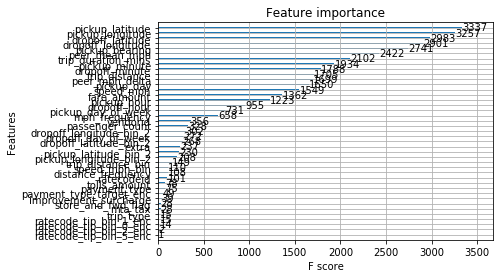

In [14]:
# plot feature importance
plt = xgb.plot_importance( model_xgb_tip_recorded )
#print( type( plt ) )

# FAIL!?!
#fig = plt.gcf()
# #fig.savefig('output.png')
# fig.savefig( "plots/tip-recorded-prediction-features-xgb.png" )

## What Will Tip Be? Expressed as a Percentage

In [4]:
# create train & test sets: omit tip or related values
X_trips = trips.drop( columns=[ "tip_percent", "tip_amount", "total_amount", "tip_percent_bin" ] )
y_trips = trips.tip_percent

X_train, X_test, y_train, y_test = train_test_split( X_trips, y_trips, random_state=42 )
eval_set = [ ( X_test, y_test ) ]

## Build XGBoost Model, Run on GPU

In [5]:
# TRAIN & CALC EARLY STOPPING BEST-ITERATION
start_time = get_time()

param = { "tree_method":"gpu_hist", "silent":False, "max_depth":10, "n_estimators":500, "n_jobs":cores }
model_xgb_tip_percentage = xgb.XGBRegressor( **param )

# set eval set & early stopping
model_xgb_tip_percentage.fit( X_train, y_train, early_stopping_rounds=50, eval_set=eval_set, verbose=True, eval_metric="rmse" )

print_time( start_time, get_time() )

# best RMSE *before* adding peer mph, delta and bearing
# 4.85855
# same after adding peer mph, delta and bearing

# 4.85428 after adding mean target encoding for payment type

2018.06.01 17:35
[0]	validation_0-rmse:13.5556
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:12.3849
[2]	validation_0-rmse:11.3482
[3]	validation_0-rmse:10.4333
[4]	validation_0-rmse:9.62865
[5]	validation_0-rmse:8.92369
[6]	validation_0-rmse:8.30842
[7]	validation_0-rmse:7.77469
[8]	validation_0-rmse:7.31313
[9]	validation_0-rmse:6.91654
[10]	validation_0-rmse:6.57792
[11]	validation_0-rmse:6.29045
[12]	validation_0-rmse:6.04702
[13]	validation_0-rmse:5.84271
[14]	validation_0-rmse:5.67111
[15]	validation_0-rmse:5.52821
[16]	validation_0-rmse:5.40961
[17]	validation_0-rmse:5.31146
[18]	validation_0-rmse:5.23063
[19]	validation_0-rmse:5.16389
[20]	validation_0-rmse:5.10959
[21]	validation_0-rmse:5.06511
[22]	validation_0-rmse:5.02896
[23]	validation_0-rmse:4.99979
[24]	validation_0-rmse:4.97487
[25]	validation_0-rmse:4.95542
[26]	validation_0-rmse:4.93795
[27]	validation_0-rmse:4.92477
[28]	validation_0-rmse:4.91382
[29]	validation_0-rmse:4.9054

## Plot Important Features for Tip Percentage Prediction

In [10]:
# # work around for bork3d feature importance plot for xgboost
# d = dict(zip( X_test.columns, model_xgb_tip_percentage.feature_importances_))
# ss = sorted( d, key=d.get, reverse=True )
# #top_names = ss[ 0:n_features ]
# #ss


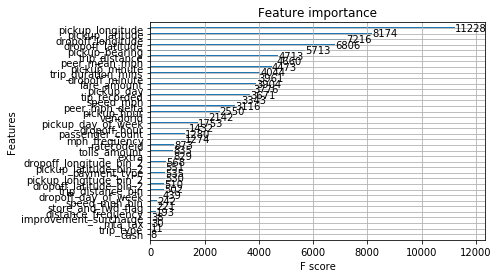

In [11]:
# https://stackoverflow.com/questions/40081888/xgboost-plot-importance-figure-size
# Kludgey wrapper to set figsize.  B0rk3d too
# def my_plot_importance( booster, figsize, **kwargs): 
    
#     fig, ax = plt.subplots( 1, 1, figsize=figsize )
#     return plot_importance( booster=booster, ax=ax, **kwargs )

# my_plot_importance( model_xgb_tip_percentage, figsize=( 16, 0 ) )

plt = xgb.plot_importance( model_xgb_tip_percentage )

In [6]:
# get stats for first model, using test dataset
predictions_tip_percent = model_xgb_tip_percentage.predict( X_test )
# some tips were predicted as negatives!
predictions_tip_percent_clipped = [ max( tip, 0.0 ) for tip in predictions_tip_percent ]

rmse = sqrt( mean_squared_error( y_test, predictions_tip_percent ) )
print( "RAW rmse      [%f]" % ( rmse ) )
r2 = r2_score( y_test, predictions_tip_percent )
print( 'RAW R-squared [%f]' % r2 )

rmse = sqrt( mean_squared_error( y_test, predictions_tip_percent_clipped ) )
print( "POS rmse [%f]" % ( rmse ) )

# super low when other directly related values are included in training set, obviously
#rmse [0.338194]

# RAW rmse      [4.855230]
# RAW R-squared [0.841146]
# POS rmse [4.854883]

RAW rmse      [4.860655]
RAW R-squared [0.840791]
POS rmse [4.860322]


## How Many Predictions Are Negative?

In [7]:
negative_tips = 0
for tip in predictions_tip_percent:
    if ( tip < 0 ):
        negative_tips += 1

print( negative_tips )
print( predictions_tip_percent.min() )
print( len( predictions_tip_percent ) )


108431
-3.65264
363958


In [8]:
# does combining "tip_recorded * tip_prediction_percent" yield anything better?
predictions_combined = predictions_tip_recorded * predictions_tip_percent_clipped
#predictions_combined[ 0:10 ].tolist()

NameError: name 'predictions_tip_recorded' is not defined

In [9]:
rmse = sqrt( mean_squared_error( y_test, predictions_combined ) )
print( "Combined rmse [%f]" % ( rmse ) )
# Nope!

NameError: name 'predictions_combined' is not defined

## Build LightGB Model, Run on GPU

In [10]:
start_time = get_time()

# 'gpu' and 'num_threads' get us GPU and parallel processing on CPU
lgb_params = {
               "device": "gpu",
               "num_threads": 12,
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learnprint_timeing_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':1 
              }

model_lgb = lgb.train( lgb_params, lgb.Dataset( X_train, label=y_train ), 500 )
predictions_tip_percent_lgbm = model_lgb.predict( X_test )

print( 'RAW R-squared for LightGBM is %f' % r2_score( y_test, predictions_tip_percent_lgbm ) )
print( 'RAW RMSE      for LightGBM is %f' % np.sqrt( mean_squared_error( y_test, predictions_tip_percent_lgbm ) ) )

finish_time = get_time()
print_time( start_time, finish_time )

# Before adding bearing, peer mph and mph delta
# RAW R-squared for LightGBM is 0.840568
# RAW RMSE      for LightGBM is 4.864064

# 2018.05.16 17:53
# RAW R-squared for LightGBM is 0.840552
# RAW RMSE      for LightGBM is 4.864311
# Time to process: [19.275200605392456] seconds

# 2018.05.25 14:40
# RAW R-squared for LightGBM is 0.840512
# RAW RMSE      for LightGBM is 4.864918
# Time to process: [47.710164070129395] seconds



2018.06.01 17:41
RAW R-squared for LightGBM is 0.840579
RAW RMSE      for LightGBM is 4.863897
2018.06.01 17:42
Time to process: [81.49203634262085] seconds


## Plot Important Features

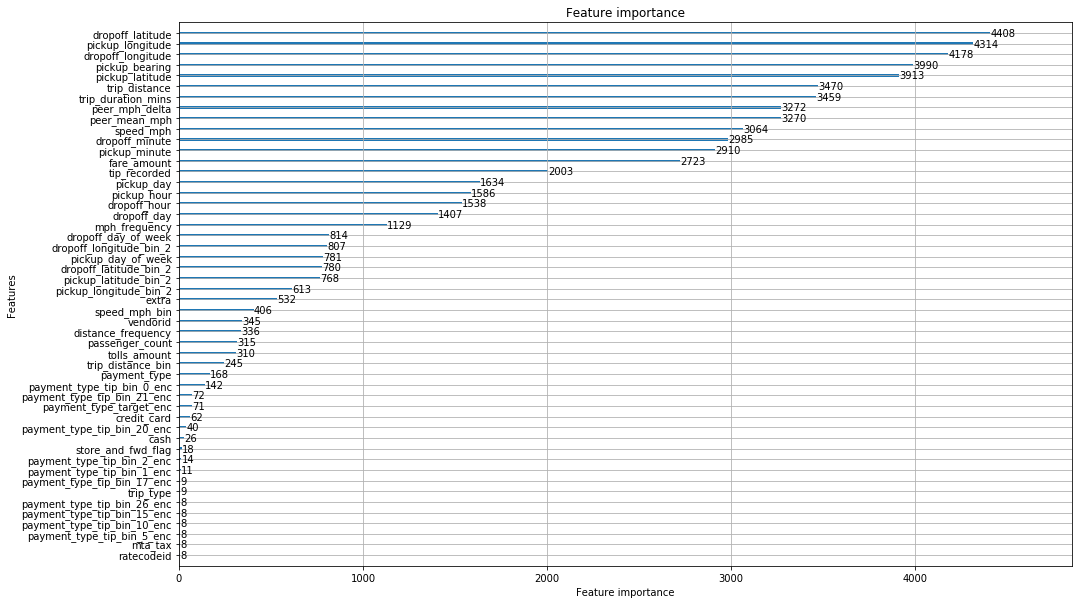

In [11]:
lgb.plot_importance( model_lgb, max_num_features=50, figsize=( 16, 10 ) )

## Plot Residuals for LightGBM Model (Which is Moderately Better)

Text(0.5,0,'Residuals = Actual - Predicted Values')

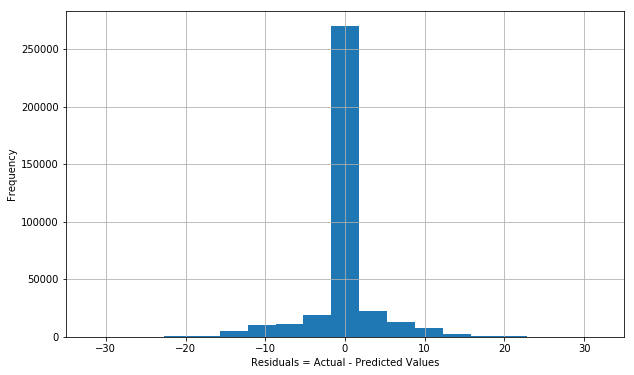

In [12]:
# create df w/ results
data = { 'tip_percentage':y_test,'prediction':predictions_tip_percent_lgbm, 'residuals': y_test - predictions_tip_percent_lgbm }
results_df = pd.DataFrame( data )

# Pandas provides quick plots
plt = results_df.residuals.plot.hist( bins=50, figsize=( 10, 6 ), grid=True, xlim=( -35, 35 ) )
plt.set_xlabel( "Residuals = Actual - Predicted Values" )

## Run LightGBM as Multiclass

In [4]:
# create train & test sets: omit tip or related values
X_trips = trips.drop( columns=[ "tip_percent", "tip_amount", "total_amount", "tip_percent_bin" ] )
y_trips = trips.tip_percent_bin

X_train, X_test, y_train, y_test = train_test_split( X_trips, y_trips, random_state=42 )
eval_set = [ ( X_test, y_test ) ]

In [5]:
start_time = get_time()

# 'gpu' and 'num_threads' get us GPU and parallel processing on CPU
lgb_params = {
               "device": "gpu",
               "num_threads": 12,
               'max_depth':-1, # unlimited
               'feature_fraction': 0.75,
               'metric': 'multi_logloss',
               'metric_freq':10,
               'bagging_fraction': 0.75, 
               'learnprint_timeing_rate': 0.03, 
               'objective': 'multiclass', 
               'bagging_seed': 42, 
               'bagging_freq':1,
               'verbose':5,
               'num_class':130,
               #'eval_set':eval_set, 
               #'eval_metric':[ 'multi_error' ],
               #'num_boost_round':500,
               #'early_stopping_round':50,  
               'task':"train",
               'min_data_in_leaf':20 # default value
              }

model_lgb_tip_percent_bin = lgb.train( lgb_params, lgb.Dataset( X_train, label=y_train ), 500 )
predictions_tip_percent_bin_lgb = model_lgb_tip_percent_bin.predict( X_test )

accuracy = accuracy_score( y_test, predictions_tip_percent_bin_lgb )
print( "Accuracy: %.2f%%" % ( accuracy * 100.0 ) )

finish_time = get_time()
print_time( start_time, finish_time )



2018.06.03 12:48


KeyboardInterrupt: 

In [21]:
# predictions_tip_percent_bin_lgb[ 0:10 ]

In [22]:
# from sklearn.metrics import confusion_matrix
# accuracy = confusion_matrix( y_test, predictions_tip_percent_bin_lgb )
# print( "Accuracy: %.2f%%" % ( accuracy * 100.0 ) )

## K Nearest Neighbor Is S l o o o o o o o w: 2.3 Hours

In [23]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import MinMaxScaler

# # create train & test sets: omit tip or related values
# X_trips = trips.drop( columns=[ "tip_percent", "tip_amount", "total_amount", "tip_percent_bin" ] )
# y_trips = trips.tip_percent_bin

# X_train, X_test, y_train, y_test = train_test_split( X_trips, y_trips, random_state=42 )
# eval_set = [ ( X_test, y_test ) ]

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform( X_train )

# # we must apply the scaling to the test set that we computed for the training set
# X_test_scaled = scaler.transform( X_test )


In [20]:
# start_time = get_time()

# class_count = len( trips.tip_percent_bin.unique() )
# class_count

# knn = KNeighborsClassifier( n_neighbors=class_count, n_jobs=cores ) #still runs on one core :-(
# knn.fit( X_train_scaled, y_train )

# print( 'Accuracy of K-NN classifier on training set: {:.2f}'.format( knn.score( X_train_scaled, y_train ) ) )
# print( 'Accuracy of K-NN classifier on test set: {:.2f}'.format( knn.score( X_test_scaled, y_test ) ) )

# print_time( start_time, get_time(), interval="hours" )

# # 2018.05.16 17:53
# # Accuracy of K-NN classifier on training set: 0.74
# # Accuracy of K-NN classifier on test set: 0.73
# # 2018.05.16 20:12
# # Time to process: [2.316765977475378] hours

In [19]:
# # pickle it, before it gets lost and I have to recompute!
# filename = "models/tip-percent-bins-130-knn-2018-05.16.pickle"
# pickle.dump( knn, open( filename, 'wb' ) )

In [21]:
# start_time = get_time()
# # load the model from disk
# loaded_model = pickle.load( open( filename, 'rb' ) )
# result = loaded_model.score( X_test, y_test )
# print( result )
# print_time( start_time, get_time() )